In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
pd.options.plotting.backend = "plotly"
pd.set_option('display.max_columns', 150, 'display.max_rows', 100, 'display.max_colwidth', True)
import spacy
import pandas as pd
# Load Spacy English language model
nlp = spacy.load('en_core_web_sm')
%matplotlib inline

In [123]:
GREY1 = "#231F20";GREY2 = "#414040";GREY3 = "#555655";GREY4 = "#646369";GREY5 = "#76787B";GREY6 = "#828282";GREY7 = "#929497";GREY8 = "#A6A6A5";GREY9 = "#BFBEBE";BLUE1 = "#174A7E";
BLUE2 = "#4A81BF";BLUE3 = "#94B2D7";BLUE4 = "#94AFC5";BLUE5 = "#22435e";BLUE6 = "#95B3D7";RED1 = "#C3514E";RED2 = "#E6BAB7";RED3 = "#800000";GREEN1 = "#0C8040";GREEN2 = "#9ABB59"
GREEN3 = "#31859C";GREEN4 = "#4BACC6";GREEN5 = "#93CDDD";ORANGE1 = "#F79747";ORANGE2 = "#FAC090"; BLUE_CPD1= "#137FA7";BLUE_CPD2= "#00385D";BLUE_CPD3= "#EAF6FE";BLUE_CPD4= "#51BCE1"

# Find spam mesasge using Naive Bayes

## Introduction:

The goal of this analysis is to detect and classify spam messages accurately. 

In this analysis, the data underwent several preprocessing steps, such as removing punctuation and stop words, and applying stemming to the text. 

We visualized the most frequent words in spam and ham messages. Afterward, we transformed our string data to a vectorized format using CountVector, which gave us the frequency of each word in a document. 

Finally, we applied Bernoulli Naive Bayes and Gaussian Naive Bayes models and used hyperparameters to improve the ROC_AUC and reduce false positives and negatives.

## Methodology:
Firstly, the "sms_spam.csv" dataset was loaded using pandas. 

Then, the data was preprocessed, which involved removing punctuations, stop words, and digits, as well as applying stemming to the text.

Afterward, the most frequent words in spam and ham messages were visualized using WordCloud.

The next step was to transform the string data into a vectorized format using CountVectorizer. 

The data was then split into input and target variables. A LabelEncoder was applied to convert the target variable into binary format.

Finally, two models were fitted and tested on the data - Bernoulli Naive Bayes and Gaussian Naive Bayes.



## Short Introduction Bayes' theorem

Bayes' theorem describes the relationships between dependent events and is used to revise the estimate of the probability of an event based on evidence from another event.

The formula for conditional probability is:

$P(A|B) = \frac{P(A \cap B)}{P(B)}$

where the probability of A is dependent on what happened with event B.

Bayes' theorem tells us that the best estimate of $P(A|B)$ is based on $P(A \cap B)$ and $P(B)$.

The formula can be rearranged to:

$P(A \cap B) = P(A|B) * P(B)$

we know that $P(A \cap B)$ = $P(B \cap A)$

$P(A \cap B) = P(B|A) * P(A)$

and used in the following formulation of Bayes' theorem:

$P(A|B) = \frac{P(B|A) * P(A)}{P(B)}$

where:

$P(A|B)$ = posterior probability = probability that we want to calculate

$P(B|A)$ = likelihood

$P(B)$ = prior probability

$P(A)$ = marginal likelihood

In [124]:
df=pd.DataFrame({
    "target": ["spam"]*20 + ["ham"]*80, 
    "viagra": ["yes"]*4 +["no"]*16+["yes"]+["no"]*79
    })
df.head()

,target,viagra
0,spam,yes
1,spam,yes
2,spam,yes
3,spam,yes
4,spam,no


In [125]:
df_priors= (
         df
         .groupby("target", as_index=False)
         .agg(ham_prop= ("viagra", "count") )
         .assign(
            total= df.viagra.count()
            )
         )
df_marg_lik= (
         df
         .groupby("viagra", as_index=False)
         .agg(viag_prop= ("viagra", "count") )
            )

df_ham_viag_prop = pd.concat([df_priors,df_marg_lik], axis=1)
df_ham_viag_prop

,target,ham_prop,total,viagra,viag_prop
0,ham,80,100,no,95
1,spam,20,100,yes,5


### Short example:

Lets explain bayes theorem with an example. we want to find our posterior probability that email is spam given viagra word appears.

Suppose we know prior probability of spam is 20%. we also know that 5%(marginal likelihood) of all messages contained word viagra as we can see from the table above.

we know probability spam is highly dependant on word viagra appearing so we can not calculate it as p(spam) * p(viagra) = 0.2 *.05 = .01

we also have the information that 4 out of 20 message has word viagra in spam messages. 

By applying Bayes' theorem to this evidence, we can compute a posterior probability that measures how likely the message is to be spam.

First we will calculate the liklihood p(viagra|spam)

In [126]:
(
    df
    .groupby(["target", "viagra"], as_index=False)
    .agg(freq= ("viagra", "count")  )
    .merge(df_priors, how="left", on = "target")
    .merge(df_marg_lik, how="left", on = "viagra")
    .assign(        
    p_v_s_liklihood= lambda df_:  df_.freq / df_.ham_prop,
    priors_prob= lambda df_:  df_.ham_prop/ df_.total,    
    marg_lik = lambda df_: df_.viag_prop/df_.total,
    post_prob= lambda df_:  df_.p_v_s_liklihood * df_.priors_prob / df_.marg_lik
    )
)


,target,viagra,freq,ham_prop,total,viag_prop,p_v_s_liklihood,priors_prob,marg_lik,post_prob
0,ham,no,79,80,100,95,0.9875,0.8,0.95,0.831579
1,ham,yes,1,80,100,5,0.0125,0.8,0.05,0.200000
2,spam,no,16,20,100,95,0.8000,0.2,0.95,0.168421
3,spam,yes,4,20,100,5,0.2000,0.2,0.05,0.800000


The application of Bayes' theorem to problem can be solved by following formula:

$P(spam|Viagra) = \frac{P(Viagra|spam) * P(spam)}{P(Viagra)}$

If the posterior probability is above 50%, the message is likely spam and should be filtered.

We can find using a table as above:

$P(spam|viagra)$ = posterior probability = the missing probability

$P(viagra|spam)$ = likelihood = (4/20) = 0.2

$P(spam)$ = prior probability = 20/100 = 0.2

$P(viagra)$ = marginal likelihood of appearing in any message = 5/100 = 0.05


**Posterior Probability:**

$P(Spam|Viagra) = \frac{P(Viagra|Spam) * P(Spam)}{P(Viagra)} = \frac{(4/20) * (20/100)}{(5/100)} = 0.80$

**Joint Probability:**

Now we can also calculate $P(Viagra \cap Spam)$ since we have $P(viagra|spam)$

$P(Viagra \cap Spam) = P(Viagra|Spam) * P(Spam) = (4/20) * (20/100) = 0.04$

which is 4 times greater than the probability $P(spam) * P(viagra) = 0.2 * 0.05 = 0.01$ if the events were independent.

$P(Viagra \cap Ham) = P(Viagra|Ham) * P(Ham) = (1/80) * (80/100) = 0.01$

$P(Viagra) = P(Viagra \cap Spam) + P(Viagra \cap Ham) = 0.04 + 0.01 = 0.05$

## Load Data sms data

In [127]:
df= pd.read_csv("/Users/waleedidrees/Dropbox/Python_Projects/My_Projects/classification_models/sms_spam.csv")
df.head()

,type,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 cash needs your URGENT collection. 09066364349 NOW from Landline not to lose out! Box434SK38WP150PPM18+"
4,spam,okmail: Dear Dave this is your final notice to collect your 4* Tenerife Holiday or #5000 CASH award! Call 09061743806 from landline. TCs SAE Box326 CW25WX 150ppm


In [128]:
df.type.value_counts()

ham     4812
spam    747 
Name: type, dtype: int64

In [129]:
from nltk.stem.snowball import SnowballStemmer
stemming = SnowballStemmer(language = 'english')

In [130]:
allow_postags = set(['NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN'])

In [131]:
df_final = (
        df
        .assign(text= lambda x: x.text.str.lower())
        # Remove punctuations
        .assign(text=lambda x: [" ".join(token.text for token in nlp(text) if not token.is_punct ) for text in x.text])
        # Remove Stop words.
        .assign(text=lambda x: [" ".join(token.text for token in nlp(text) if not token.is_stop) for text in x.text])
        # Find any digits replace with space.
        .assign(text=lambda x: x.text.str.replace(r'\d+', " ", regex=True))
        # find any symbols other than alphabets and replace with space.
        .assign(text=lambda x: x.text.str.replace(r'[^a-zA-Z]', " ", regex=True))
        # word stemming
        .assign(text= lambda x : [" ".join(stemming.stem(token.text) for token in nlp(text)) for text in x.text] )
        .rename(columns= {"type": "target"})
)
df_final

,target,text
0,ham,hope have good week check
1,ham,k thank
2,ham,cbe pay
3,spam,complimentari star ibiza holiday cash need urgent collect landlin lose box sk wp ppm
4,spam,okmail dear dave final notic collect tenerif holiday cash award landlin tcs sae box cw wx ppm
...,...,...
5554,ham,great role model give wish day miracl god reason wish knew nt ve look young great day
5555,ham,awesom rememb time got somebodi high time diesel v
5556,spam,prize custom t c www t c biz p min polo ltd suit london w j hl busi
5557,spam,sms ac jsco energi high u know channel day ur leadership skill r strong psychic repli an w question end repli end jsco


In [132]:
df_final.head()

,target,text
0,ham,hope have good week check
1,ham,k thank
2,ham,cbe pay
3,spam,complimentari star ibiza holiday cash need urgent collect landlin lose box sk wp ppm
4,spam,okmail dear dave final notic collect tenerif holiday cash award landlin tcs sae box cw wx ppm


## Most Frequest words in the spam messages

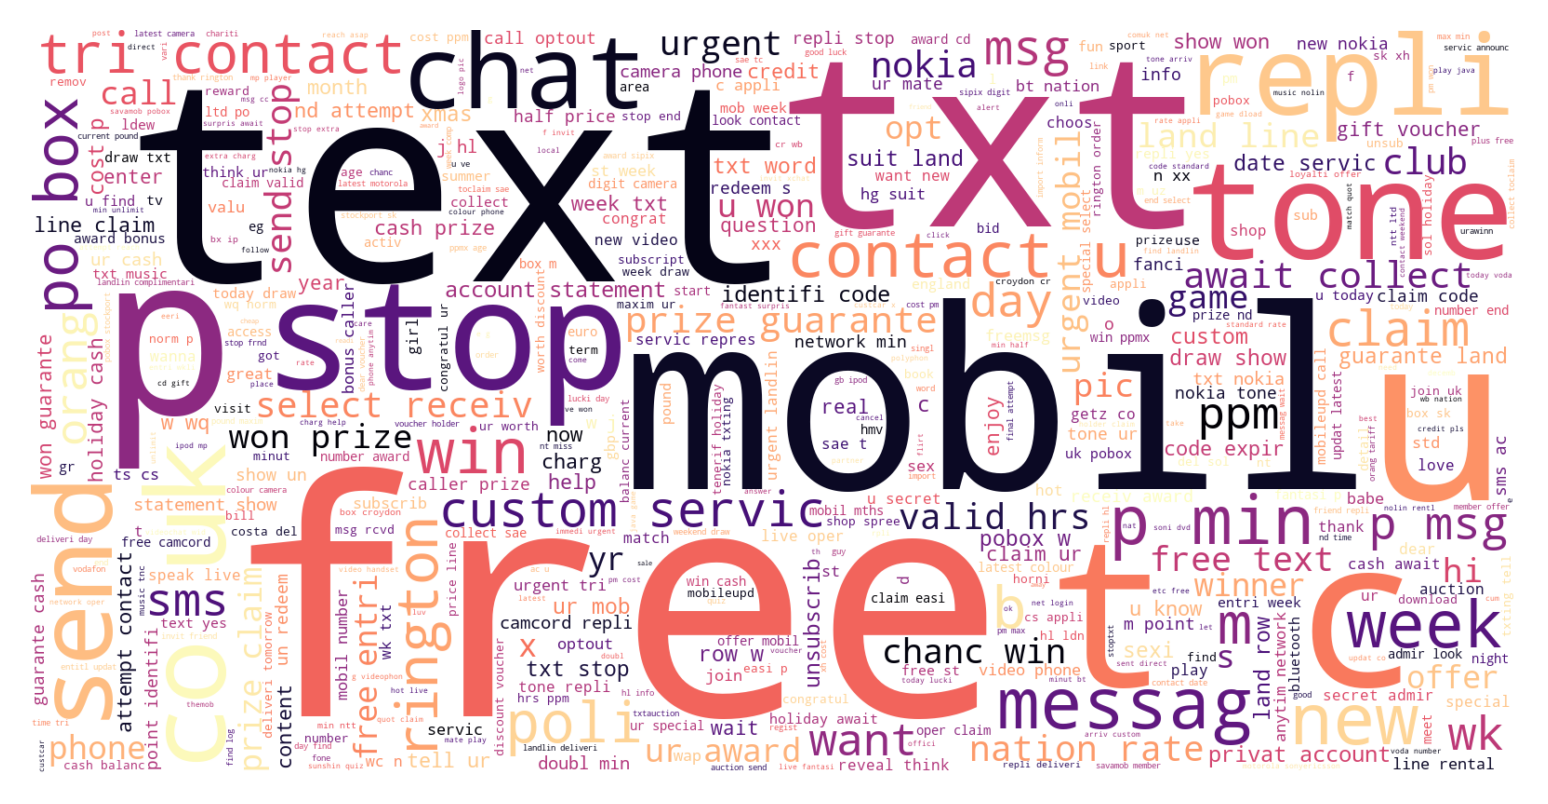

In [133]:
from wordcloud import WordCloud

plt.figure(dpi=300)

text = df_final.query("target == 'spam'").text.str.cat(sep=' ')
wordcloud = WordCloud(max_font_size=350, max_words=500, background_color="white", width=1600, height=800, colormap= "magma",

                      random_state=1905).generate(text)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

# Display the plot
plt.show()

## Most Frequent words in Ham messages is shown in the plot below.

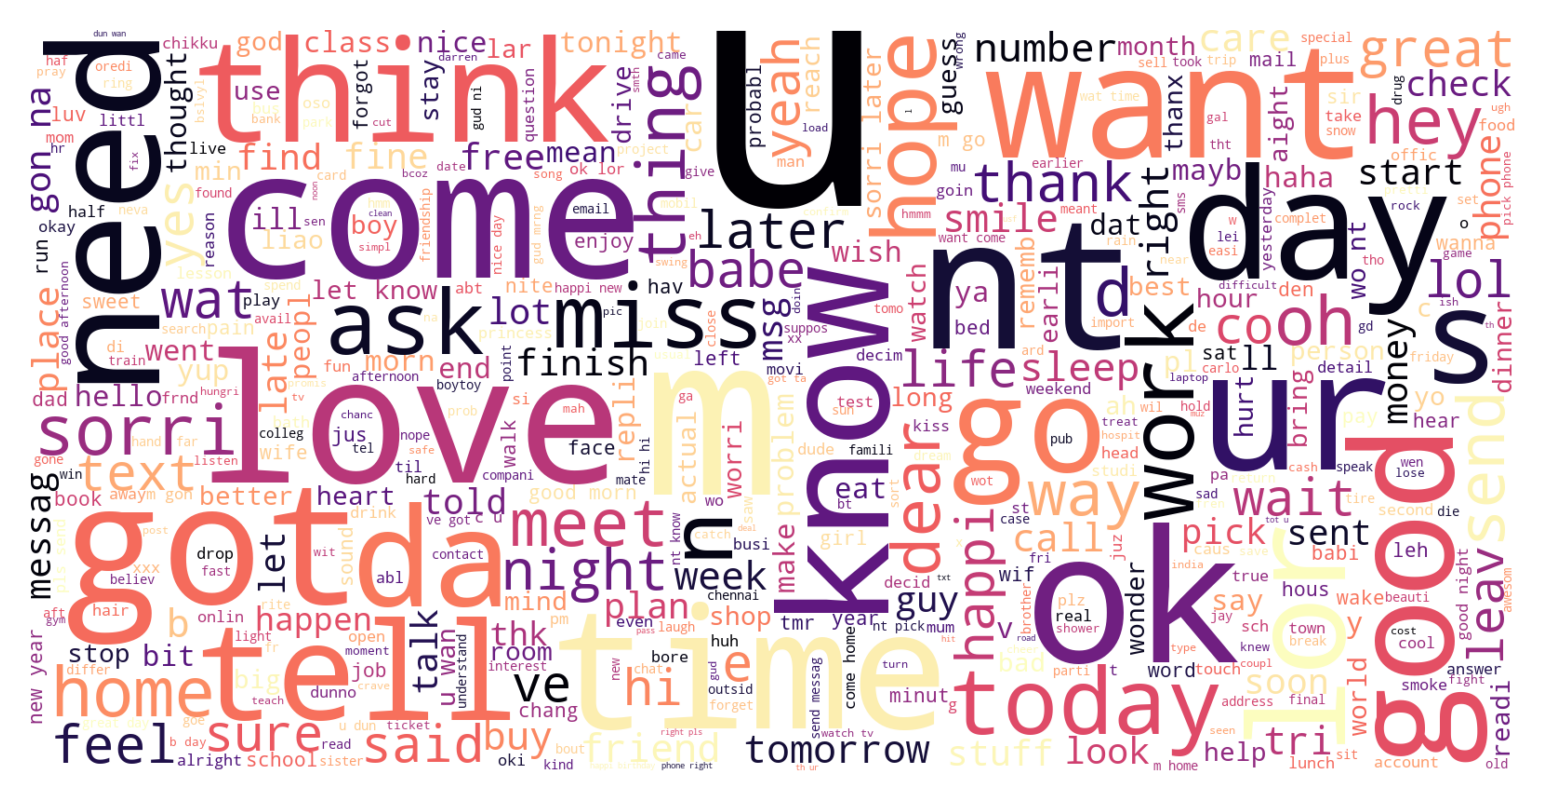

In [134]:
plt.figure(dpi=300)
text = df_final.query("target == 'ham'").text.str.cat(sep=' ')
wordcloud = WordCloud(max_font_size=350, max_words=500, background_color="white", width=1600, height=800,colormap= "magma",
                      random_state=1905).generate(text)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

# Display the plot
plt.show()

In [135]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

## Transform text data using Count Vectorizer into numeric frequency data

In [136]:
target_variable= "target"
df_x = df_final.drop(columns=target_variable)
df_y = df_final[target_variable]
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df_y = encoder.fit_transform(df_y)

text_pipe= Pipeline (
        steps =[("count",CountVectorizer(
    encoding='utf-8',     
    #ngram_range= (1,2)    
        ))
        ]
          )

prep = ColumnTransformer(
    transformers= [('s', text_pipe, 'text') ]
    )

df_x= pd.DataFrame(prep.fit_transform(df_x).toarray(), columns= prep.get_feature_names_out()  )

## Tests Train Data Split

In [137]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_x, df_y, test_size = 0.25, stratify=df_y, random_state =42
    )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4169, 6205), (4169,), (1390, 6205), (1390,))

In [138]:
from sklearn.metrics import confusion_matrix, classification_report, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
def cl_scores(true, predicted):  
    results= pd.DataFrame.from_dict(classification_report(y_test, predicted, output_dict=True))    
    return results
def eval_scores(actuals, pred):
    res= pd.DataFrame({ 
    "accuracy": [accuracy_score(actuals, pred)], 
    "recall": [recall_score(actuals, pred)],
    "roc_auc": [roc_auc_score(actuals, pred)],
    "precision": [precision_score(actuals, pred)]})
    return res

# Naive Bayes Algorithm Selection for Different Tasks

* **Spam email:** 
The spam email classification task often involves a binary classification problem, where the goal is to classify emails into spam or not spam. In this case, the input features are usually the frequency of specific words in the email text, and the Bernoulli Naive Bayes algorithm is commonly used. The reason is that in spam classification, the presence or absence of each word is more important than their frequency. Additionally, Bernoulli Naive Bayes handles binary features well, which is the case for word presence or absence.
* **Sentiment analysis:** 
Sentiment analysis is another common NLP task that aims to determine the sentiment of a text, usually as positive or negative. In this case, the input features are usually the presence or absence of specific words in the text, and Bernoulli Naive Bayes is also often used. This is because Bernoulli Naive Bayes is well-suited for binary data, where the presence or absence of each word is a binary feature.
* **Image classification:** 
In image classification tasks, the goal is to classify images into different categories. The input features are often the pixel intensities of the image, and in this case, Gaussian Naive Bayes is more appropriate. This is because the pixel intensities are continuous variables, and Gaussian Naive Bayes assumes that the features are normally distributed.

* **Medical diagnosis:**
In medical diagnosis, the goal is often to predict whether a patient has a particular disease or not based on their medical history and test results. In this case, the input features are usually continuous variables, such as blood pressure, cholesterol levels, and age, and Gaussian Naive Bayes is often used. This is because the continuous variables can be modeled using a Gaussian distribution.

* **Weather prediction:**
In weather prediction, the goal is often to predict whether it will rain or not based on weather features such as temperature, humidity, and wind speed. In this case, Gaussian Naive Bayes is more appropriate because the features are continuous variables and can be modeled using a Gaussian distribution.

In [139]:
data = [
    ['Spam email', 'Word frequency counts', 'Spam or not spam', 'Bernoulli'],
    ['Sentiment', 'Word presence/absence', 'Positive or negative', 'Bernoulli'],
    ['Image', 'Pixel intensity values (0-255)', 'Image class (e.g., face)', 'Gaussian'],
    ['Medical', 'Blood pressure, cholesterol, age', 'Disease or healthy', 'Gaussian'],
    ['Weather', 'Temperature, humidity', 'Rain or no rain', 'Gaussian']
]
columns = ['Dataset', 'Features', 'Target', 'Naive Bayes Algorithm']

df = pd.DataFrame(data, columns=columns)
df

,Dataset,Features,Target,Naive Bayes Algorithm
0,Spam email,Word frequency counts,Spam or not spam,Bernoulli
1,Sentiment,Word presence/absence,Positive or negative,Bernoulli
2,Image,Pixel intensity values (0-255),"Image class (e.g., face)",Gaussian
3,Medical,"Blood pressure, cholesterol, age",Disease or healthy,Gaussian
4,Weather,"Temperature, humidity",Rain or no rain,Gaussian


# Models

In [140]:
from sklearn.utils.class_weight import compute_class_weight
sample_weight = compute_class_weight(
             class_weight='balanced', classes=  np.unique(y_train) ,y= y_train
             ) 
MLA= {    
    "gnb": GaussianNB(),     
    "bnb": BernoulliNB(),        
    }  
pipes = {}
for x in MLA.keys():    
        pipe= Pipeline(steps=[("model", MLA[x])])
        pipes[x]=  pipe
pipes.keys()

dict_keys(['gnb', 'bnb'])

In [141]:
from sklearn.metrics import roc_auc_score
cl_report= []
scores= []
auc_scores =[]
for model in MLA.keys():    
    pipes[model].fit(X_train, y_train )     
    cl_report.append(cl_scores(y_test, pipes[model].predict(X_test)).assign(model = model))            
    scores.append( eval_scores(y_test, pipes[model].predict(X_test) ).assign(model = model))   

pd.concat(scores).sort_values("accuracy", ascending=False)

,accuracy,recall,roc_auc,precision,model
0,0.970504,0.855615,0.921989,0.919540,bnb
0,0.843165,0.919786,0.875521,0.458667,gnb


In [142]:
for x in MLA.keys():    
    print(pipes[x].get_params())

{'memory': None, 'steps': [('model', GaussianNB())], 'verbose': False, 'model': GaussianNB(), 'model__priors': None, 'model__var_smoothing': 1e-09}
{'memory': None, 'steps': [('model', BernoulliNB())], 'verbose': False, 'model': BernoulliNB(), 'model__alpha': 1.0, 'model__binarize': 0.0, 'model__class_prior': None, 'model__fit_prior': True, 'model__force_alpha': 'warn'}


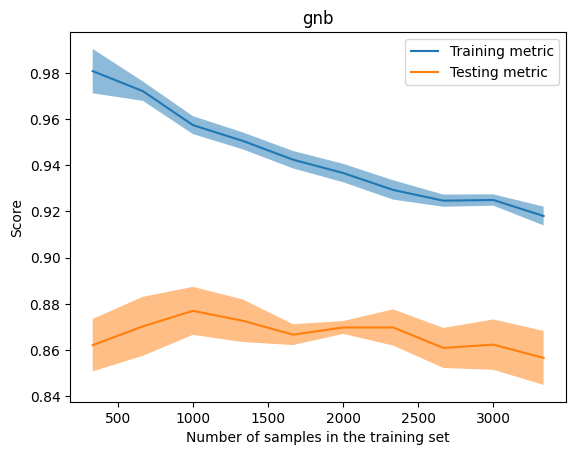

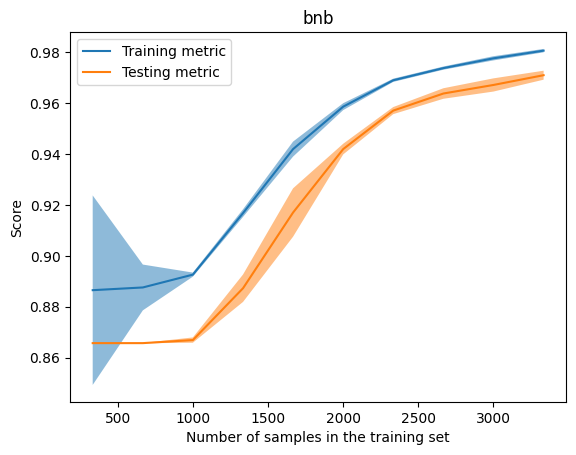

In [143]:
from sklearn.model_selection import StratifiedKFold
cv_split = StratifiedKFold(n_splits= 10, random_state=10 , shuffle=True)
from sklearn.model_selection import LearningCurveDisplay
for x in MLA.keys():            
    fig= LearningCurveDisplay.from_estimator(
    pipes[x], X_train, y_train, cv=5, n_jobs=-1, score_type= "both", train_sizes= np.linspace(0.1, 1, 10 )
    )   
    plt.title(x)

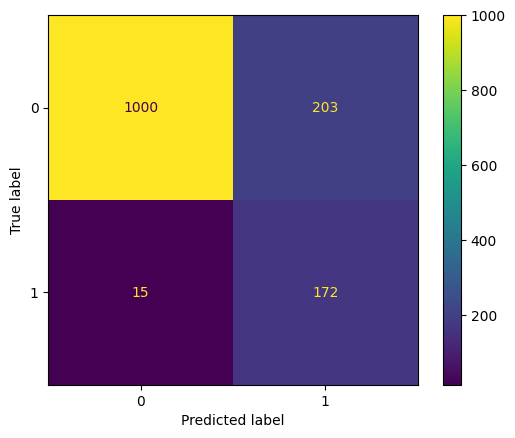

In [144]:
model = "gnb"

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test,pipes[model].predict(X_test), labels= pipes[model]["model"].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=pipes[model]["model"].classes_)
disp.plot()
plt.show()

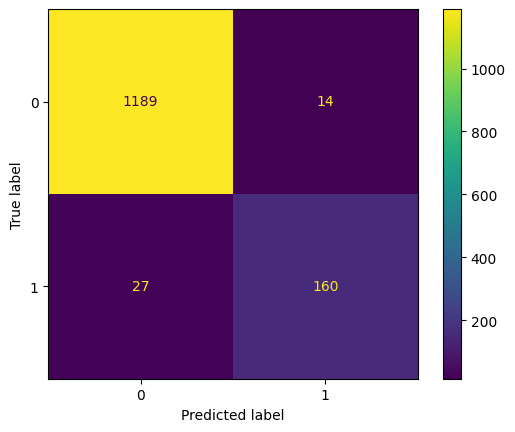

In [145]:
model = "bnb"
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test,pipes[model].predict(X_test), labels= pipes[model]["model"].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=pipes[model]["model"].classes_)
disp.plot()
plt.show()

# Hyper Parameters
Lets define out hyperparameters

In [146]:
grid_smoothing=  np.arange(0.02,.06,.01)
grid_alphas=  np.arange(.001, .05,.001)
grid_smoothing, grid_alphas

(array([0.02, 0.03, 0.04, 0.05]),
 array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
        0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
        0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
        0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
        0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
        0.046, 0.047, 0.048, 0.049]))

In [147]:
MLA_params = {  
    "gnb": [{        
         "model__var_smoothing": grid_smoothing     
            }],    
    "bnb": [{        
        'model__alpha': grid_alphas,        
            }]        
    } 

# Run Random CV for all models

In [148]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

tune_params = {}
best_model_scores= {}
best_models = {}
cl_report= []
scores =[]

for x in MLA.keys():
#for x in ["lgb"]:
    grid_cv= GridSearchCV(
            pipes[x],
            param_grid= MLA_params[x],
            cv= cv_split,
            scoring='roc_auc',
            #scoring='accuracy',            
            #refit = "recall",            
            verbose= 0,
            n_jobs= -1 )

    tune_grid =grid_cv.fit(X_train, y_train)

    tune_params[x]= pd.DataFrame.from_dict(tune_grid.cv_results_ ).assign(model= x)

    best_model_scores[x] = [tune_grid.best_score_]
    best_models[x] = tune_grid.best_estimator_
    best_model = tune_grid.best_estimator_
    best_model.fit(X_train, y_train)        
    cl_report.append(cl_scores(y_test,best_model.predict(X_test)).assign(model=x))
    scores.append(eval_scores(y_test,best_model.predict(X_test)).assign(model=x))
    

## Evaluation Scores
The Model with best ROC/AUC over 10kfold cv has .8495 score on training data

In [149]:
pd.DataFrame.from_dict(best_model_scores)

,gnb,bnb
0,0.983718,0.991986


In [150]:
pd.concat(scores)

,accuracy,recall,roc_auc,precision,model
0,0.984892,0.930481,0.961916,0.956044,gnb
0,0.983453,0.935829,0.963343,0.940860,bnb


In [151]:
for x in MLA.keys():
    final_pipe= best_models[x]
    final_pipe = final_pipe.fit(X_train, y_train)
    print(final_pipe)

Pipeline(steps=[('model', GaussianNB(var_smoothing=0.049999999999999996))])
Pipeline(steps=[('model', BernoulliNB(alpha=0.049))])


After hyperparamter tuning we see that bnb is performing better than gnb and lgb are performing well. 

# Cross validation on best models

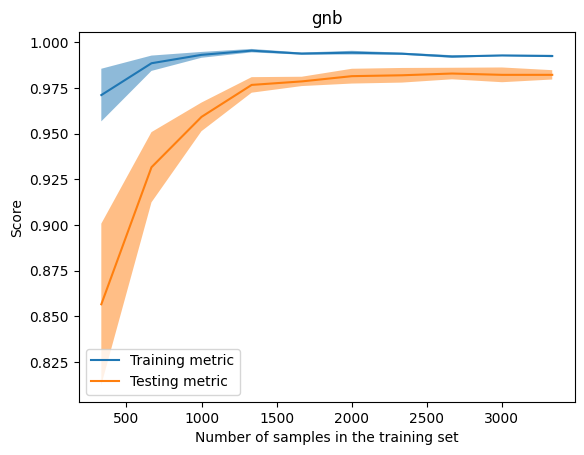

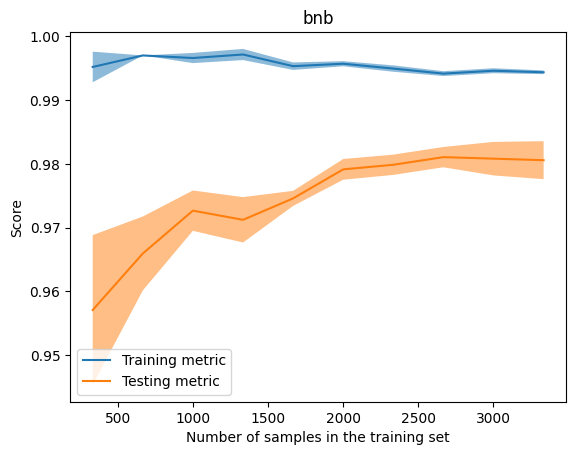

In [152]:
for x in MLA.keys():            
    fig= LearningCurveDisplay.from_estimator(
    best_models[x], X_train, y_train, cv=5, n_jobs=-1, score_type= "both", train_sizes= np.linspace(0.1, 1, 10 )
    )   
    plt.title(x)

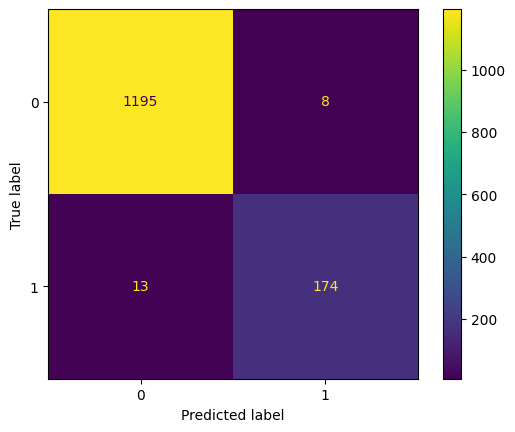

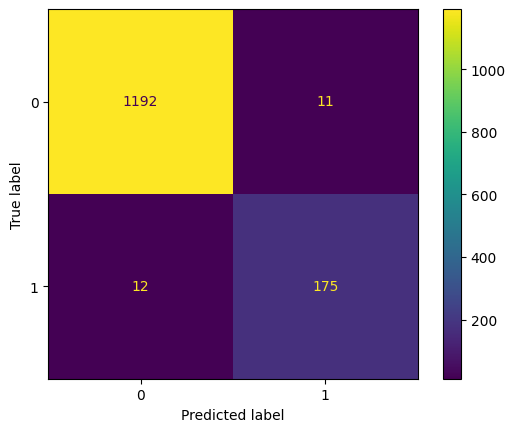

In [153]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for x in MLA.keys():
    final_pipe= best_models[x]
    final_pipe = final_pipe.fit(X_train, y_train)
    cm = confusion_matrix(y_test,final_pipe.predict(X_test), labels=final_pipe["model"].classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=final_pipe["model"].classes_)
    disp.plot()
    plt.show()

**Results:**

* The most frequent words in spam messages were "call" "free" "txt" and "mobile."  

* The most frequent words in ham messages were "u" "call" "get" "love" and "go." 

* Using hyperparameters we manage to improve the roc_auc and reduce the false positive and false negatives significantly as can be seen in the cofusion matrixes.

* The Bernoulli Naive Bayes model yielded an accuracy of 96.3%, while the Gaussian Naive Bayes model had an accuracy of 96.1% on test data.

**Conclusion:**

* The preprocessing steps taken in this analysis helped improve the performance of the models.

* The visualization of the most frequent words in spam and ham messages helped identify key features in the data. 

* The Bernoulli Naive Bayes and Gaussian Naive Bayes models performed well in detecting spam messages.

* Overall, this analysis demonstrates the effectiveness of machine learning algorithms in detecting spam messages.

In [154]:
model= "bnb"
final_pipe= best_models[model]
final_pipe = final_pipe.fit(X_train, y_train)

In [155]:
probs= pd.DataFrame(final_pipe.predict_proba(X_test), columns=["positive", "negative"]  ).round(3)
probs

,positive,negative
0,1.000,0.000
1,1.000,0.000
2,0.000,1.000
3,1.000,0.000
4,0.013,0.987
...,...,...
1385,1.000,0.000
1386,1.000,0.000
1387,1.000,0.000
1388,0.000,1.000


In [156]:
df_prob= X_test.copy().reset_index(drop=True)
df_prob["target"]= y_test

## The Table below shows the probabilities of the sms that is span

In [157]:
df_prob[["positive", "negative"]]= probs
df_prob[["target", "positive"]]. sort_values("positive", ascending= False)

,target,positive
0,0,1.0
829,0,1.0
809,0,1.0
808,0,1.0
807,0,1.0
...,...,...
797,1,0.0
773,1,0.0
771,1,0.0
767,1,0.0
